<a href="https://colab.research.google.com/github/iliya1984/DevML/blob/main/computer_vision/image_classification/homer_bart_classifiction_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homer/Bart image classification with feature extraction

### Importing the libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import save_model

from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

tf.__version__

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'2.15.0'

In [4]:
%run '/content/drive/MyDrive/Workspace/Computer Vision/cv_common.ipynb'

Common library was successfully loaded


### Loading the images

In [37]:
zip_file_path = f'{datasets_directory}/Simpsons/simpsons.zip'
working_directory = './content/simpsons'
data_extract_path = f'{working_directory}/datasets'
train_set_path = f'{data_extract_path}/simpsons/training_set'
test_set_path = f'{data_extract_path}/simpsons/test_set'
model_directory = f'{working_directory}/models'

In [38]:
zip_object = zipfile.ZipFile(file=zip_file_path, mode='r')
zip_object.extractall(data_extract_path)
zip_object.close()

In [10]:
# We can configure some parameters to make modifications to the original images,
# which is very useful when we have few images of each class.
# As you can see here, there are many other parameters that can be configured.
# Using this function, in addition to the original images, we will also have new images
# with application of these pre-processing
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
# Indicates that the images will be accessed every eight. As we have few images, we put this small value

# As the name suggests, this parameter will mix the images,
# they will be accessed in a completely random order to prevent the neural network
# from memorizing the order of the images. Otherwise, the neural network could
# learn the order of the images and not their features
train_dataset = training_generator.flow_from_directory(train_set_path,
                                                        target_size = (64, 64),
                                                        batch_size = 8,
                                                        class_mode = 'categorical',
                                                       shuffle = True)
train_dataset.classes

Found 196 images belonging to 2 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [39]:
train_dataset.class_indices

In [13]:
# To test, we set this parameter to FALSE because when testing,
# the order of the images makes no difference.
# If we leave the value equals TRUE, we will not be able to associate the
# predictions with the expected outputs
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(test_set_path,
                                                     target_size = (64, 64),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 73 images belonging to 2 classes.


## Building and training the neural network

In [14]:
network = Sequential()
network.add(Conv2D(32, (3,3), input_shape = (64,64,3), activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))

network.add(Conv2D(32, (3,3), activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))

network.add(Conv2D(32, (3,3), activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))


network.add(Flatten())

network.add(Dense(units = 3137, activation='relu'))
network.add(Dense(units = 3137, activation='relu'))
network.add(Dense(units = 2, activation='softmax'))

In [15]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 32)          0

In [16]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [17]:
history = network.fit_generator(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50


<ipython-input-17-70460a0dc6fc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = network.fit_generator(train_dataset, epochs=50, validation_data=test_dataset)


25/25 [==============================] - 7s 80ms/step - loss: 0.7525 - accuracy: 0.5867 - val_loss: 0.5960 - val_accuracy: 0.6164
Epoch 2/50
25/25 [==============================] - 1s 41ms/step - loss: 0.6025 - accuracy: 0.6633 - val_loss: 0.6077 - val_accuracy: 0.6027
Epoch 3/50
25/25 [==============================] - 1s 31ms/step - loss: 0.5166 - accuracy: 0.7194 - val_loss: 0.4294 - val_accuracy: 0.8356
Epoch 4/50
25/25 [==============================] - 1s 31ms/step - loss: 0.4923 - accuracy: 0.7908 - val_loss: 0.3579 - val_accuracy: 0.8630
Epoch 5/50
25/25 [==============================] - 1s 27ms/step - loss: 0.4129 - accuracy: 0.7959 - val_loss: 0.3808 - val_accuracy: 0.8219
Epoch 6/50
25/25 [==============================] - 1s 31ms/step - loss: 0.3737 - accuracy: 0.8163 - val_loss: 0.4538 - val_accuracy: 0.7397
Epoch 7/50
25/25 [==============================] - 1s 27ms/step - loss: 0.4143 - accuracy: 0.8163 - val_loss: 0.2823 - val_accuracy: 0.8767
Epoch 8/50
25/25 [======

## Evaluating the neural network

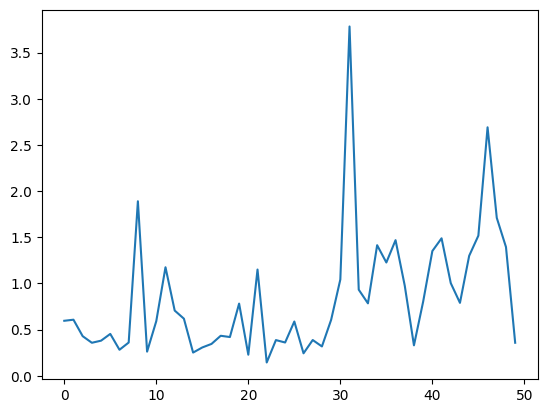

In [18]:
plt.plot(history.history['val_loss']);

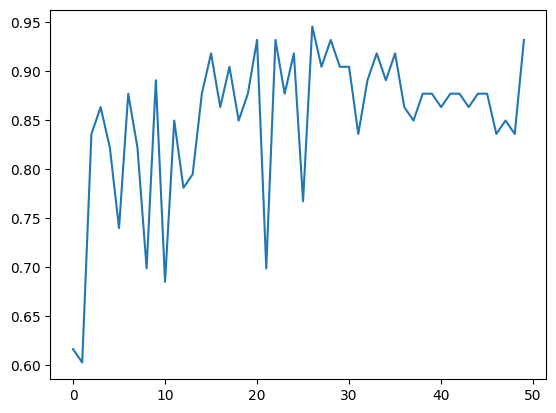

In [19]:
plt.plot(history.history['val_accuracy']);

In [20]:
predictions = network.predict(test_dataset)
predictions = np.argmax(predictions, axis = 1)
predictions

73/73 [==============================] - 0s 2ms/step


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [21]:
accuracy_score(test_dataset.classes, predictions)

0.9315068493150684

<Axes: >

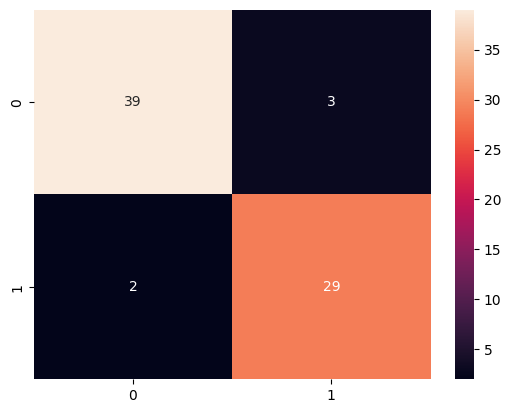

In [22]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [23]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.91      0.94      0.92        31

    accuracy                           0.93        73
   macro avg       0.93      0.93      0.93        73
weighted avg       0.93      0.93      0.93        73



## Saving and loading the model

In [25]:
create_empty_directory(model_directory)
model_json = network.to_json()
with open(f'{model_directory}/network.json','w') as json_file:
  json_file.write(model_json)

./content/simpsons/models directory was created


In [26]:
network_saved = save_model(network, f'{model_directory}/weights.hdf5')

<ipython-input-26-607e19d7058f>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, f'{model_directory}/weights.hdf5')


In [27]:
with open(f'{model_directory}/network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 64, 64, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 64, 64, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bia

In [29]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights(f'{model_directory}/weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [30]:
network_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 32)          0

### Classifying one single image

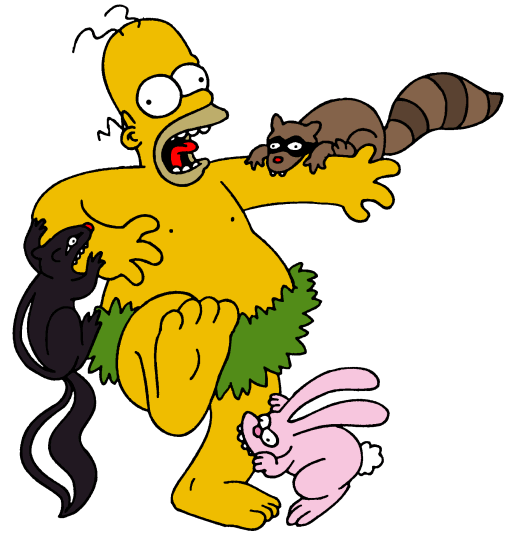

In [31]:
image = cv2.imread(f'{test_set_path}/homer/homer15.bmp')
cv2_imshow(image)

In [32]:
image = cv2.resize(image, (64, 64))
image = image / 255
image = image.reshape(-1, 64, 64, 3)
image.shape

(1, 64, 64, 3)

In [35]:
result = network_loaded(image)
result = np.argmax(result)
result

1

In [36]:
if result == 0:
  print('Bart')
else:
  print('Homer')

Homer
